### Importing and Reading HI-Small_Trans.csv

In [1]:
import pandas as pd 
import numpy as np

In [2]:
df = pd.read_csv('SAML-D.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          int64  
 3   Receiver_account        int64  
 4   Amount                  float64
 5   Payment_currency        object 
 6   Received_currency       object 
 7   Sender_bank_location    object 
 8   Receiver_bank_location  object 
 9   Payment_type            object 
 10  Is_laundering           int64  
 11  Laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB


In [4]:
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [5]:
df['Payment_currency'].value_counts()

UK pounds          9099293
Euro                117164
Turkish lira         27996
Swiss franc          27492
Dirham               27263
Pakistani rupee      27196
Naira                27143
US dollar            26061
Yen                  25562
Moroccan dirham      25395
Mexican Peso         24852
Albanian lek         24778
Indian rupee         24657
Name: Payment_currency, dtype: int64

In [6]:
df['Is_laundering'].value_counts(normalize=True)


0    0.998961
1    0.001039
Name: Is_laundering, dtype: float64

### Feature Transformation

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
currency_conversion_rates = {
    'US Dollar': 1.0,
    'Euro': 1.03, 
    'Swiss franc': 1.09, 
    'Yuan': 0.14, 
    'Shekel': 0.28,
    'Indian rupee': 0.012, 
    'UK pounds': 1.24, 
    'Yen': 0.0066, 
    'Ruble': 0.01, 
    'Bitcoin': 95781.21,
    'Canadian Dollar': 0.7, 
    'Australian Dollar': 0.63, 
    'Mexican Peso': 0.049, 
    'Saudi Riyal': 0.27, 
    'Brazil Real': 0.17,
    'Turkish lira': 0.028,
    'Dirham': 0.27,
    'Pakistani rupee': 0.0036,
    'Naira': 0.00066,
    'Yen': 0.0065,
    'Moroccan dirham': 0.10,
    'Albanian lek': 0.010,

}

df['Amount (USD)'] = df.apply(lambda row: row['Amount'] * currency_conversion_rates.get(row['Payment_currency'], 1), axis=1)

In [9]:

df['Time'] = pd.to_datetime(df['Date'] +' '+ df['Time'])

df['year'] = df['Time'].dt.year  
df['month'] = df['Time'].dt.month  
df['day'] = df['Time'].dt.day  
df['hour'] = df['Time'].dt.hour
df['min'] = df['Time'].dt.minute
df['second'] = df['Time'].dt.second 

df.drop(columns=['Date', 'Time','Amount'], inplace=True)

cat_col = ['Sender_account', 'Receiver_account', 'Received_currency', 
           'Payment_currency', 'Payment_type', 'Sender_bank_location','Receiver_bank_location','Laundering_type']
for col in cat_col:
    df[col] = LabelEncoder().fit_transform(df[col])


In [10]:
df.head()

,Sender_account,Receiver_account,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type,Amount (USD),year,month,day,hour,min,second
0,255277,180462,10,10,16,16,1,0,11,1809.3460,2022,10,7,10,35,19
1,43554,548141,10,1,16,15,5,0,14,7464.3536,2022,10,7,10,35,20
2,8553,287765,10,10,16,16,3,0,20,17767.2656,2022,10,7,10,35,20
3,157249,626370,10,10,16,16,0,0,13,14749.8000,2022,10,7,10,35,21
4,281324,248338,10,10,16,16,1,0,11,142.9100,2022,10,7,10,35,21


### Training a Baseline ML Model

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


In [12]:
import networkx as nx

G = nx.DiGraph()

for _, row in df.iterrows():
    G.add_edge(row['Sender_account'], row['Receiver_account'], weight=row['Amount (USD)'])

df['degree_centrality'] = df['Sender_account'].map(nx.degree_centrality(G))
df['pagerank'] = df['Sender_account'].map(nx.pagerank(G))


In [13]:
# Convert numerical features into tensors
feature_cols = ["Amount (USD)", "year", "month", "day", "hour", "min", "second",
                "degree_centrality", "pagerank"]

node_features = torch.tensor(df[feature_cols].values, dtype=torch.float)

# Convert labels to tensor (1 = Money laundering, 0 = Legitimate)
labels = torch.tensor(df["Is_laundering"].values, dtype=torch.long)

# Create edge index for PyTorch Geometric (source → destination)
edge_index = torch.tensor(df[["Sender_account", "Receiver_account"]].values.T, dtype=torch.long)

# Create PyG Data object
data = Data(x=node_features, edge_index=edge_index, y=labels)

# Print PyG data structure
print(data)

Data(x=[9504852, 9], edge_index=[2, 9504852], y=[9504852])


In [14]:
import torch.nn.functional as F
import torch.nn as nn

# Define the Enhanced GNN Model
class EnhancedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(EnhancedGNN, self).__init__()

        # Initial Graph Convolutional Layer (GCN)
        self.gcn1 = GCNConv(input_dim, hidden_dim)

        # Graph Attention Layer (GAT)
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=heads, concat=False)

        # Fully Connected Layer for Node Classification
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        # Apply GCN
        x = self.gcn1(x, edge_index)
        x = F.relu(x)

        # Apply GAT for attention-based feature learning
        x = self.gat1(x, edge_index)
        x = F.relu(x)

        # Fully connected layers for **node-level classification**
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)  # Log Softmax for Multi-class Classification
    
# Instantiate the model
model = EnhancedGNN(input_dim=node_features.shape[1], hidden_dim=16, output_dim=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


In [15]:
# Move data to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")


Epoch 0 - Loss: 28.6817
Epoch 10 - Loss: 0.1616
Epoch 20 - Loss: 0.1551
Epoch 30 - Loss: 0.1021
Epoch 40 - Loss: 0.0804
Epoch 50 - Loss: 0.0609
Epoch 60 - Loss: 0.0790
Epoch 70 - Loss: 0.0669
Epoch 80 - Loss: 0.0667
Epoch 90 - Loss: 0.0570


In [19]:
df_test = pd.read_csv('SAML-D.csv')

df_test['Amount (USD)'] = df_test.apply(lambda row: row['Amount'] * currency_conversion_rates.get(row['Payment_currency'], 1), axis=1)


df_test['Time'] = pd.to_datetime(df_test['Date'] +' '+ df_test['Time'])

df_test['year'] = df_test['Time'].dt.year  
df_test['month'] = df_test['Time'].dt.month  
df_test['day'] = df_test['Time'].dt.day  
df_test['min'] = df_test['Time'].dt.minute
df_test['hour'] = df_test['Time'].dt.hour
df_test['second'] = df_test['Time'].dt.second 

df_test.drop(columns=['Date', 'Time','Amount'], inplace=True)

cat_col = ['Sender_account', 'Receiver_account', 'Received_currency', 
           'Payment_currency', 'Payment_type', 'Sender_bank_location','Receiver_bank_location','Laundering_type']
for col in cat_col:
    df_test[col] = LabelEncoder().fit_transform(df_test[col])

import networkx as nx

G = nx.DiGraph()

for _, row in df_test.iterrows():
    G.add_edge(row['Sender_account'], row['Receiver_account'], weight=row['Amount (USD)'])

df_test['degree_centrality'] = df_test['Sender_account'].map(nx.degree_centrality(G))
df_test['pagerank'] = df_test['Sender_account'].map(nx.pagerank(G))

# Convert numerical features into tensors
feature_cols = ["Amount (USD)", "year", "month", "day", "hour", "min", "second",
                "degree_centrality", "pagerank"]

node_features = torch.tensor(df_test[feature_cols].values, dtype=torch.float)

# Convert labels to tensor (1 = Money laundering, 0 = Legitimate)
labels = torch.tensor(df_test["Is_laundering"].values, dtype=torch.long)

# Create edge index for PyTorch Geometric (source → destination)
edge_index = torch.tensor(df_test[["Sender_account", "Receiver_account"]].values.T, dtype=torch.long)

# Create PyG Data object
data_test = Data(x=node_features, edge_index=edge_index, y=labels)

# Print PyG data structure
print(data_test)


Data(x=[9504852, 9], edge_index=[2, 9504852], y=[9504852])


In [20]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    out = model(data_test.x, data_test.edge_index)  # Raw logits (shape: [num_nodes, 2])

    # Convert logits to probabilities using softmax
    probs = F.softmax(out, dim=1)[:, 1]  # Extract probability of class 1

    # Get predicted class labels (not for AUC)
    pred = out.argmax(dim=1)

    # Compute accuracy
    accuracy = (pred == data_test.y).sum().item() / len(data_test.y)

    # Compute AUC-ROC score
    auc_score = roc_auc_score(data_test.y.cpu().numpy(), probs.cpu().numpy())

print(f"Final Model Accuracy: {accuracy:.4f}")
print(f"Final ROC AUC Score: {auc_score:.4f}")


Final Model Accuracy: 0.9990
Final ROC AUC Score: 0.4908


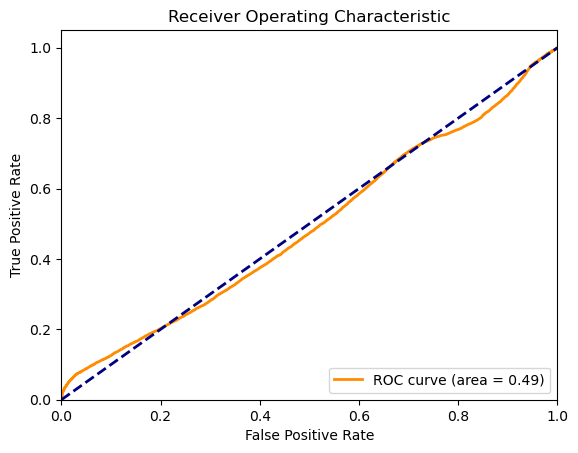

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have your model predictions (y_pred_proba) and true labels (y_true) 

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(data_test.y.cpu().numpy(), probs.cpu().numpy()) 

# Calculate AUC score
auc_score = roc_auc_score(data_test.y.cpu().numpy(), probs.cpu().numpy())

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()